In [1]:
from __future__ import division
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageFilter
from skimage import transform as tf
import random, string

In [2]:
def randomword(length):
       return ''.join(random.choice(string.uppercase) for i in range(length))

In [3]:
#test word
randomword(4)

'HDVD'

In [4]:
def create_captcha(text, shear=0, size=(100,30)):
    im = Image.new("L", size, "black")
    draw = ImageDraw.Draw(im)
    font = ImageFont.truetype(r"Coval.otf", 22)
    draw.text((2, 2), text, fill=1, font=font)
    image = np.array(im)
    affine_tf = tf.AffineTransform(shear=shear)
    image = tf.warp(image, affine_tf)
    return image / image.max()

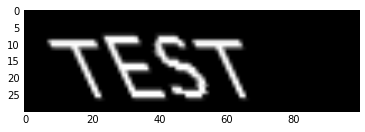

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
image = create_captcha("TEST", shear=0.5)
plt.imshow(image, cmap="gray")

In [6]:
def clean_captcha(image):
    image = image.convert('L').filter(ImageFilter.GaussianBlur(radius = 2))
    #image = image.point(lambda x: 255 if x > 190 or x == 0 else x)
    #image = image.point(lambda x: 0 if x < 255 else 255)    
    plt.imshow(np.array(image), cmap="gray")
    return image

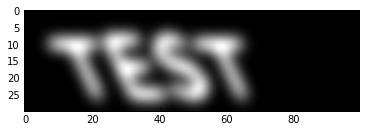

In [7]:
im = Image.fromarray(image*255)
clean_image = clean_captcha(im)

In [8]:
from skimage.measure import label, regionprops

def segment_image_new(image):
    labeled_image = label(image > 0)
    subimages = []
    partitions = regionprops(labeled_image)
    centroids = [region.centroid for region in partitions]
    centroids = sorted(centroids, key=lambda x: x[1])
    for c in centroids:
        for region in partitions:
            if c==region.centroid:
                start_x, start_y, end_x, end_y = region.bbox
                subimages.append(image[start_x:end_x, start_y:end_y])
    if len(subimages) == 0:
        return [image,]    
    return subimages

def segment_image(image):
    labeled_image = label(image > 0)
    subimages = []
    for region in regionprops(labeled_image):
        start_x, start_y, end_x, end_y = region.bbox
        subimages.append(image[start_x:end_x, start_y:end_y])
    if len(subimages) == 0:
        return [image,]
    return subimages

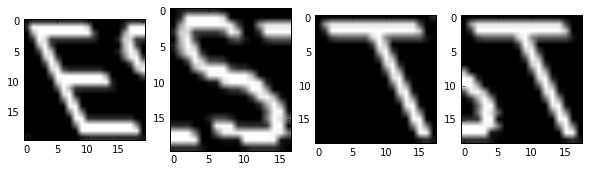

In [9]:
subimages = segment_image(image)
f, axes = plt.subplots(1, len(subimages), figsize=(10, 3))
for i in range(len(subimages)):
    axes[i].imshow(subimages[i], cmap="gray")

In [10]:
from sklearn.utils import check_random_state
random_state = check_random_state(14)
letters = list(string.uppercase)
shear_values = np.arange(0, 0.5, 0.05)

In [11]:
def generate_sample(random_state=None):
    random_state = check_random_state(random_state)
    letter = random_state.choice(letters)
    shear = random_state.choice(shear_values)
    return create_captcha(letter, shear=shear, size=(25, 25)), letters.index(letter)

The letter is : L


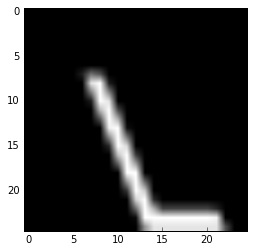

In [12]:
image, target = generate_sample(random_state)
plt.imshow(image, cmap="gray")
print("The letter is : {0}".format(letters[target]))

In [13]:
dataset, targets = zip(*(generate_sample(random_state) for i in range(15000)))
dataset = np.array(dataset, dtype='float')
targets = np.array(targets)

In [14]:
print dataset.shape


(15000, 25, 25)


In [15]:
from skimage.transform import resize

In [16]:
#dataset = np.array([resize(segment_image(sample)[0], (20, 20)) for
#sample in dataset])
#from sklearn.feature_extraction import image
#dataset = np.array([image.extract_patches_2d(d, (4, 4), max_patches=200, random_state=0) for d in dataset])
dataset = np.array([resize(segment_image(sample)[0], (20, 20)) for sample in dataset])

In [17]:
X = dataset.reshape((dataset.shape[0], dataset.shape[1] * dataset.shape[2]))
print X.shape

(15000, 400)


In [18]:
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC

X_train, X_test, y_train, y_test = train_test_split(X, targets, train_size=0.9)
print X_train.shape
print y_train
clf = LinearSVC()
clf.fit(X_train, y_train)

(13500, 400)
[11  3 10 ..., 25 23 15]


/home/lias/PycharmProjects/captcha-breaking/venv/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [19]:
y_pred = clf.predict(X_test)

In [20]:
print y_test

[ 4  1 11 ...,  4  2 16]


In [21]:
clf.score(X_test,y_test)

1.0

In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=letters))

             precision    recall  f1-score   support

          A       1.00      1.00      1.00        79
          B       1.00      1.00      1.00        58
          C       1.00      1.00      1.00        54
          D       1.00      1.00      1.00        59
          E       1.00      1.00      1.00        60
          F       1.00      1.00      1.00        64
          G       1.00      1.00      1.00        54
          H       1.00      1.00      1.00        63
          I       1.00      1.00      1.00        65
          J       1.00      1.00      1.00        55
          K       1.00      1.00      1.00        57
          L       1.00      1.00      1.00        54
          M       1.00      1.00      1.00        48
          N       1.00      1.00      1.00        53
          O       1.00      1.00      1.00        63
          P       1.00      1.00      1.00        65
          Q       1.00      1.00      1.00        53
          R       1.00      1.00      1.00   

In [23]:
def predict_captcha(im, clf):
    subimages = segment_image(im)    
    plt.imshow(im, cmap="gray")
    f, axes = plt.subplots(1, len(subimages), figsize=(10, 3))
    for i in range(len(subimages)):
        axes[i].imshow(subimages[i], cmap="gray")    
    #dataset = np.array([image.extract_patches_2d(d, (4, 4), max_patches=200, random_state=0) for d in subimages])
    dataset = np.array([resize(segment_image(sample)[0], (20, 20)) for sample in subimages])
    dataset = np.stack(dataset)    
    dataset = np.array(dataset, dtype='float')
    #X = dataset.reshape((dataset.shape[0], dataset.shape[1] * dataset.shape[2]))
    X = dataset.reshape((dataset.shape[0], dataset.shape[1] * dataset.shape[2]))
    return clf.predict(X)

TypeError: 'AxesSubplot' object does not support indexing

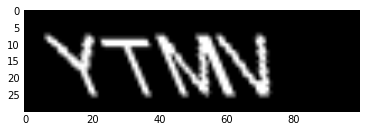

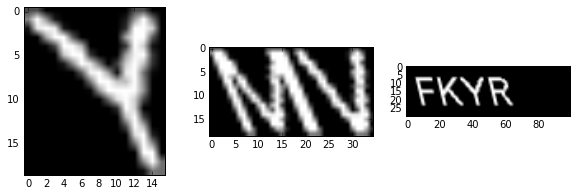

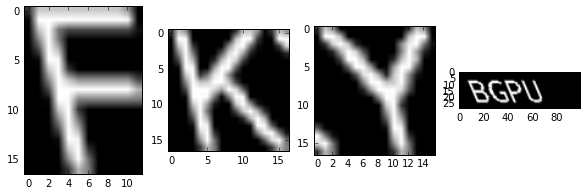

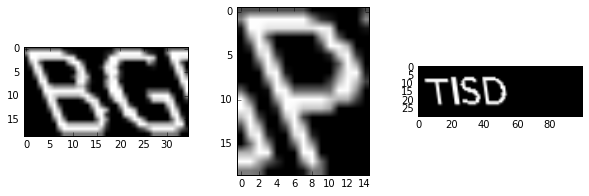

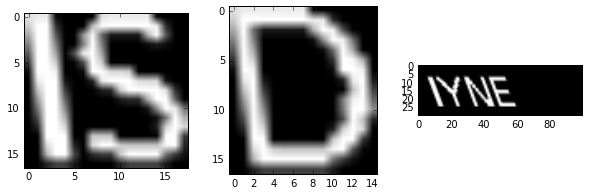

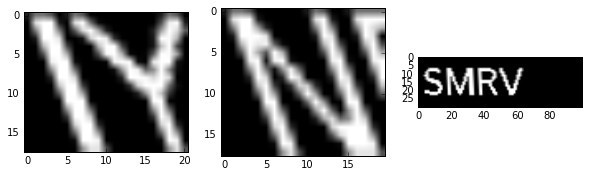

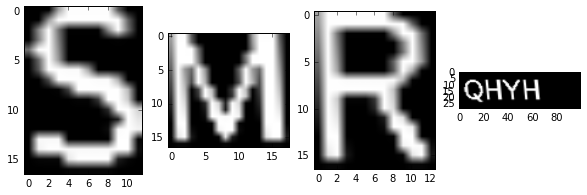

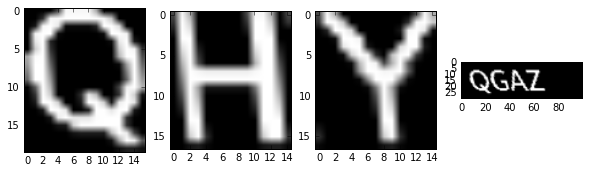

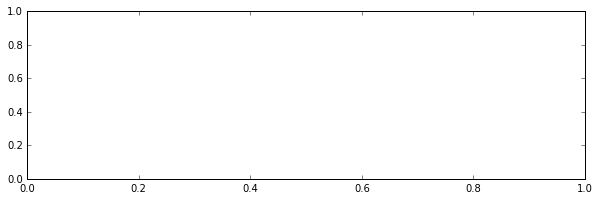

In [24]:
counter = 0
for i in range(100):
    word = randomword(4)
    new_image = create_captcha(word, shear=random.choice(shear_values))
    result = predict_captcha(new_image, clf)
    predicted_word = ''.join(letters[i] for i in result)
    if word == predicted_word:
        counter += 1

In [26]:
print counter/100
"""result = predict_captcha(new_image, clf)
print result
for i in result:
    print letters[i],"""

0.03


'result = predict_captcha(new_image, clf)\nprint result\nfor i in result:\n    print letters[i],'

In [25]:
import requests
from bs4 import BeautifulSoup
import urlparse
import urllib, cStringIO

resp = requests.get("http://localhost/captcha/register.php")
html = resp.text
soup = BeautifulSoup(html, "html5lib")
link = soup.find('img', src=True)["src"]
print link

images/60.png


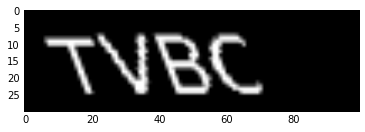

In [54]:
file = cStringIO.StringIO(urllib.urlopen("http://localhost/captcha/"+link).read())
img = Image.open(file).convert("L")
arr = np.array(img)
plt.imshow(arr, cmap="gray")

[22  1  2]
WBC


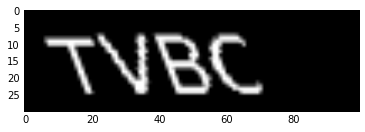

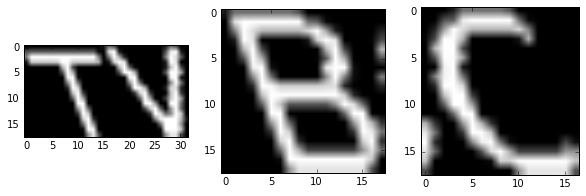

In [55]:
result = predict_captcha(arr, clf)
print result
predicted_word = ''.join(letters[i] for i in result)
print predicted_word

In [56]:
predicted_word = ''.join(letters[i] for i in result)

In [57]:
import urllib
url = 'http://localhost/captcha/register.php'
post_params = {
    'captcha': predicted_word
}
post_args = urllib.urlencode(post_params)
fp = urllib.urlopen(url, post_args)
soup = BeautifulSoup(fp)